In [1]:
import numpy as np
import pandas as pd
import surgeo
import matplotlib.pyplot as plt
import json

In [28]:
# load the zip-to-zip distance matrix
distances = np.load('zip_to_zip_distances.npy')

In [24]:
# load the zctas index
zctas = json.loads(open('zctas.json').read())

In [25]:
def get_zip_in_range(zcta, zctas, distances, dist_min, dist_max):
    index = zctas.index(zcta)
    (distances[index, :] >= dist_min) & ((distances[index, :] <= dist_max))
    return zctas[np.random.choice(np.nonzero((distances[index, :] >= dist_min) & (distances[index, :] <= dist_max))[0], 1)[0]]

def get_zip_with_error(zcta, zctas, distances, err_distances, err_probs):
    dist_max_idx = np.random.choice(np.arange(len(err_distances)), p=err_probs)
    dist_max = err_distances[dist_max_idx]
    if dist_max_idx == 0:
        dist_min = 0
    else:
        dist_min = err_distances[dist_max_idx-1]
    return get_zip_in_range(zcta, zctas, distances, dist_min, dist_max)

In [ ]:
# this is my best take at the error curve from the paper
# dist = list(np.linspace(5, 100, 100//5)) + [10000]
dist = list(np.logspace(0.1, 10, 100//5)) + [10]
probs = [.59, .63, .68, .72, .76, .78, .81, .83, .85, .86, .87, .88, .89, .895, .9, .905, .91, .9125, .925, .93, 1]
p = [probs[0]]
for idx in range(1, len(probs)):
    p.append(probs[idx]-probs[idx-1])

In [29]:
# test if my zipcode randomization corresponds with the error curve
distances_out = []
from tqdm import tqdm

zcta = '02906'
jj = zctas.index(zcta)

for retry in tqdm(range(10000)):
    ze = get_zip_with_error(zcta, zctas, distances, dist, p)
    ii = zctas.index(ze)
    distances_out.append(distances[ii, jj])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7420.51it/s]


Text(0.5, 1.0, 'Comparison between the paper error curve and experimental curve')

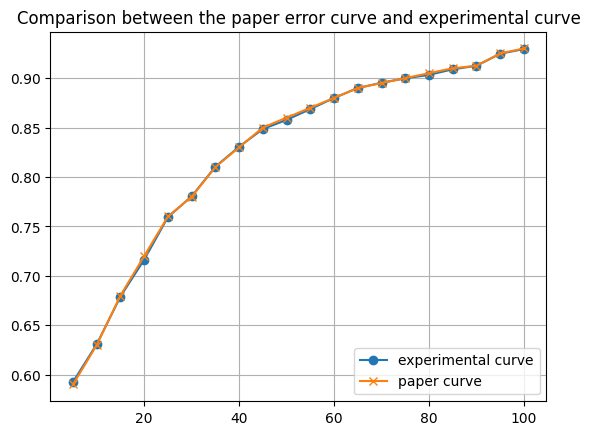

In [38]:
y, x = np.histogram(distances_out, bins = ([0] + dist))
y = y/np.sum(y)

plt.plot(x[1:-1], y[:-1].cumsum(), marker='o', label='experimental curve')
plt.plot(x[1:-1], probs[:-1], marker='x', label='paper curve')
plt.legend(loc='lower right')
plt.grid()
plt.title('Comparison between the paper error curve and experimental curve')

In [2]:
# this is all fine, let's load voter records
voters = pd.read_csv('ny_voters_clean.zip')
voters['Residence_Addresses_Zip'] = voters['Residence_Addresses_Zip'].astype(int).astype(str)

In [8]:
# let's get only the NYC zipcodes
nyc_zips = pd.read_csv('nyc_zipcodes.csv')['ZIP'].astype(str).unique()
nyc_zips

array(['11368', '10025', '10467', '11208', '11220', '11226', '11373',
       '11385', '10456', '11207', '11211', '11214', '11219', '11230',
       '11234', '11236', '11355', '11377', '10002', '10314', '10453',
       '10458', '11204', '11206', '11212', '11221', '11223', '11229',
       '11235', '10029', '10452', '10457', '10462', '10468', '11203',
       '11218', '10009', '10463', '10466', '10469', '10472', '11209',
       '11210', '11213', '11215', '11233', '11372', '11375', '10003',
       '10016', '10023', '10024', '10027', '10031', '10032', '10033',
       '10128', '10306', '10312', '10460', '10473', '11216', '11225',
       '11354', '11432', '11434', '11435', '11691', '10011', '10028',
       '10451', '10459', '10461', '11201', '11224', '11237', '11238',
       '11419', '10019', '10021', '10034', '10040', '10301', '10304',
       '10305', '10454', '10455', '10465', '10475', '11103', '11106',
       '11205', '11222', '11228', '11357', '11358', '11365', '11367',
       '11369', '113

In [39]:
# now let's create an eligible audience
eligible = voters.loc[voters['Residence_Addresses_Zip'].isin(nyc_zips)].sample(50000).reset_index(drop=True)
eligible['Swapped_Zip'] = eligible['Residence_Addresses_Zip'].map(lambda x: get_zip_with_error(x, zctas, distances, dist, p))


In [40]:
model = surgeo.SurgeoModel()
eligible_clean_probs = model.get_probabilities(eligible['Voters_LastName'], eligible['Residence_Addresses_Zip'])
eligible_clean_probs.dropna(inplace=True)
eligible_clean_probs.shape

eligible_noisy_probs = model.get_probabilities(eligible['Voters_LastName'], eligible['Swapped_Zip'])
eligible_noisy_probs.dropna(inplace=True)
eligible_noisy_probs.shape

(38793, 8)

In [20]:
# convenience functions for translating BISG to META's version
def get_stats(probabilities, threshold=0.5):
    probs = probabilities.dropna()
    result = {}
    sofar = 0
    for race in ['white', 'black', 'hispanic', 'other']:
        if race != 'other':
            result[race]= (probs[race] > threshold).mean()*100
            sofar += result[race]
        else:
            result[race] = 100-sofar
    return result

def get_zipstats(probabilities):
    probs = probabilities.dropna()
    result = {}
    sofar = 0
    for race in ['white', 'black', 'hispanic', 'other']:
        if race != 'other':
            result[race]= probs[race]*100
            sofar += result[race]
        else:
            result[race] = 100-sofar
    return result

def emd(probs1, probs2):
    result = 0
    for k in probs1:
        result += np.abs(probs1[k] - probs2[k])
    return result/2

In [46]:
# This is our eligible - clean
reference_clean = get_stats(eligible_clean_probs)
reference_clean

{'white': 32.66346223521171,
 'black': 25.214366802734233,
 'hispanic': 24.960749740344436,
 'other': 17.161421221709617}

In [47]:
# This is our eligible - noisy - note how this is more similar to general US and less to NYC
reference_noisy = get_stats(eligible_noisy_probs)
reference_noisy

{'white': 40.60268605160725,
 'black': 16.36635475472379,
 'hispanic': 24.161575541979225,
 'other': 18.86938365168973}

In [57]:
# we want to sub-sample a biased selection of the eligible audience
# we will do it by only sampling people from 1 to 20 zipcodes

repetitions = 500 # the plots I made originally are with 5000 but that takes 5 minutes to run so I'm leaving it at a smaller number
audience_size = 3000

differences_clean = []
differences_noisy = []


for repetition in tqdm(range(repetitions)):
    zipcode_count = np.random.choice(np.arange(3, 150, 1), 1)[0]
    zipcodes = np.random.choice(nyc_zips, int(zipcode_count))
    try:
        actual = eligible.loc[eligible['Residence_Addresses_Zip'].isin(zipcodes)].sample(audience_size).reset_index(drop=True)
        
        probabilities_c = model.get_probabilities(actual['Voters_LastName'], actual['Residence_Addresses_Zip'])
        probabilities_c.dropna(inplace=True)
        differences_clean.append(emd(get_stats(probabilities_c), reference_clean))
    
        probabilities_n = model.get_probabilities(actual['Voters_LastName'], actual['Swapped_Zip'])
        probabilities_n.dropna(inplace=True)
        differences_noisy.append(emd(get_stats(probabilities_n), reference_noisy))
    except Exception as e:
        pass

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.44it/s]


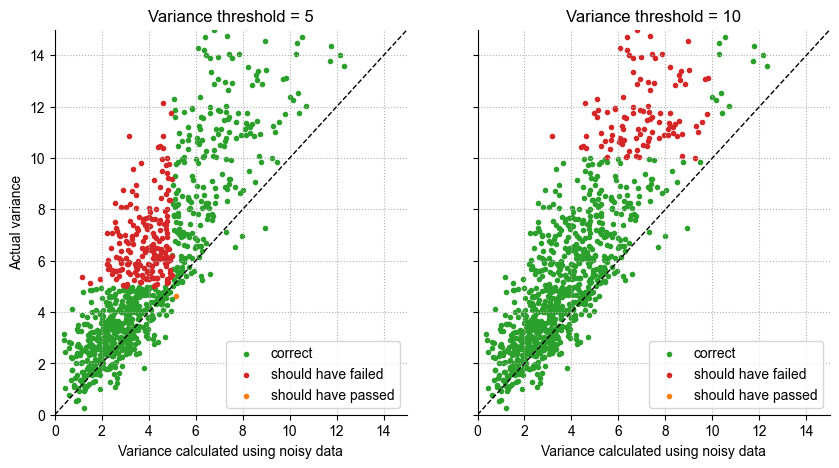

In [59]:
plt.rcParams['font.family'] = 'Arial'
f, axes = plt.subplots(1, 2, sharey=True)
differences_clean  = np.array(differences_clean)
differences_noisy  = np.array(differences_noisy)

alpha = 1

for ax, threshold in zip(axes, [5, 10]):
    
    correctly_passing = (differences_clean < threshold) & (differences_noisy < threshold)
    correctly_rejected = (differences_clean > threshold) & (differences_noisy > threshold)
    correct = correctly_passing | correctly_rejected
    
    underestimates = (differences_clean > threshold) & (differences_noisy < threshold)
    overestimates = (differences_clean < threshold) & (differences_noisy > threshold)
    
    ax.scatter(differences_noisy[correct], differences_clean[correct], 
               label='correct', color='tab:green', marker='.', alpha=alpha)
    ax.scatter(differences_noisy[underestimates], differences_clean[underestimates], 
               label='should have failed', color='tab:red', marker='.', alpha=alpha)
    ax.scatter(differences_noisy[overestimates], differences_clean[overestimates], 
               label='should have passed', color='tab:orange', marker='.', alpha=alpha)
    ax.plot([0, 40], [0, 40], color='black', ls='--', lw=1)
    ax.grid(True, ls=':')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Variance calculated using noisy data')
    
    
    ax.legend(loc='lower right', frameon=True)

    ax.set_title(f'Variance threshold = {threshold}')


    ax.set_xlim([0, 15])
    ax.set_ylim([0, 15])
axes[0].set_ylabel('Actual variance')

    

f.set_size_inches(10, 5)

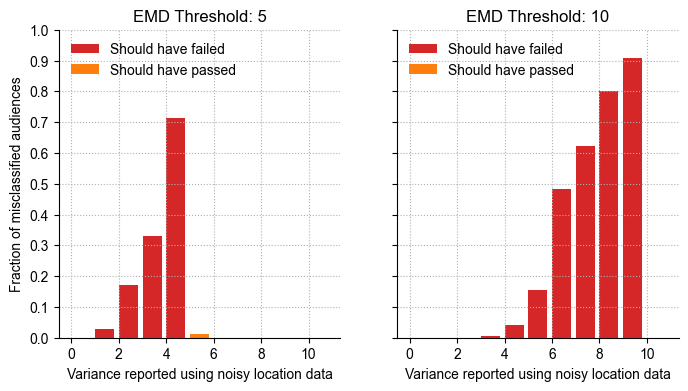

In [60]:
plt.rcParams['font.family'] = 'Arial'

bins = np.arange(0, 12, 1)
thresholds = [5, 10]
undercounts = {t: [] for t in thresholds}

f, axes = plt.subplots(1, 2, sharey=True)

for ax, threshold in zip(axes, thresholds):
    for bin_idx in range(0, len(bins)-1):
        idx = (differences_noisy >= bins[bin_idx]) & (differences_noisy < bins[bin_idx+1])
        
        correctly_passing = (differences_clean[idx] < threshold) & (differences_noisy[idx] < threshold)
        correctly_rejected = (differences_clean[idx] > threshold) & (differences_noisy[idx] > threshold)
        correct = (correctly_passing | correctly_rejected).mean()
    
        underestimates = ((differences_clean[idx] > threshold) & (differences_noisy[idx] < threshold)).mean()
        overestimates = ((differences_clean[idx] < threshold) & (differences_noisy[idx] > threshold)).mean()
     
        ax.bar([bins[bin_idx]], [underestimates], color='tab:red', align='edge', 
               label='Should have failed' if bin_idx == 0 else '')
        ax.bar([bins[bin_idx]], [overestimates], bottom = underestimates, color='tab:orange',align='edge', 
               label='Should have passed' if bin_idx == 0 else '')

    ax.set_xlabel('Variance reported using noisy location data')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, ls=':')
    ax.set_yticks(np.arange(0, 1.05, .1))
    ax.legend(loc='upper left', frameon=False)
    ax.set_title(f'EMD Threshold: {threshold}')
    


ax.set_ylim(0, 1.0)
axes[0].set_ylabel('Fraction of misclassified audiences')
f.set_size_inches(8, 4)
f.savefig('location_noise.png', dpi=200, bbox_inches='tight')
